
# Bokeh for Time Series Analysis
<hr style="border: 2px solid black;">


<img src="./images/bokeh.png" alt="bokeh Logo" width="1000"/>
<hr style="border: 2px solid black;">

<img src="./images/bokeh_at_ag_glance.png" alt="bokeh Logo" width="1000"/>
<hr style="border: 2px solid black;">
**Introduction to Bokeh**
Bokeh is an interactive visualization library for Python that targets modern web browsers for presentation.
Unlike Matplotlib, which is primarily designed for static plots, Bokeh excels at creating
interactive plots and dashboards. It can handle large datasets and streaming data,
making it suitable for real-time applications.

**Key Features of Bokeh:**

* **Interactivity:** Built-in support for zooming, panning, hovering, and other interactive tools.
* **Web-Focused:** Generates HTML and JavaScript, making it easy to embed plots in web pages.
* **High Performance:** Can handle large datasets efficiently.
* **Versatility:** Supports a wide range of plot types (lines, bars, scatter plots, etc.).

<hr style="border: 2px solid black;">


**Documentation:**

For comprehensive documentation, please refer to the official Bokeh website: [https://docs.bokeh.org/en/latest/](https://docs.bokeh.org/en/latest/)


<hr style="border: 2px solid black;">


**Lab Exercise:**

Your task is to recreate the time series analysis lab we previously conducted using Pandas,
Matplotlib, and Seaborn, but this time, utilize the Bokeh library for visualization.
This will involve:

1.  Loading and preprocessing the "AirPassengersDates.csv" dataset.
2.  Creating interactive Bokeh plots for:
    * Time series line plots
    * Bar plots of aggregated data
    * Visualizing mean and standard deviation
    * Outlier detection
    * Resampling (upsampling and downsampling)
    * Lag analysis
    * Autocorrelation

Pay close attention to Bokeh's features for interactivity (tools, hover effects) and
its handling of data sources. Aim to replicate the insights and visualizations
from the previous lab while leveraging Bokeh's strengths.

Good luck!
<hr style="border: 2px solid black;">

Loading BokehJS ...

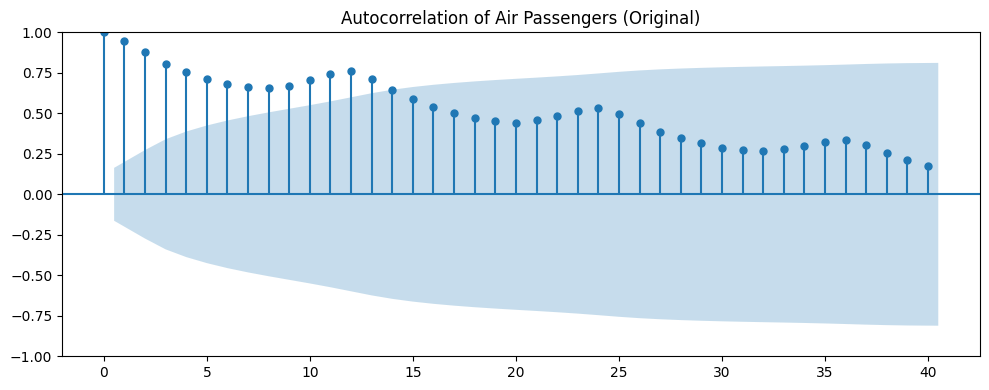

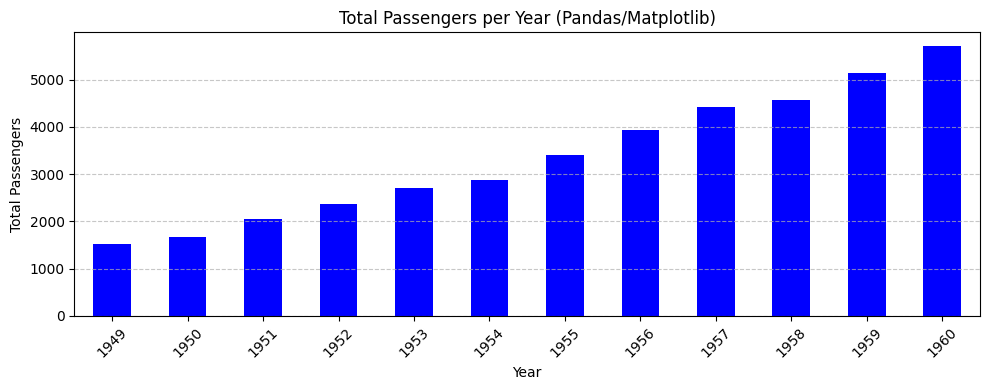

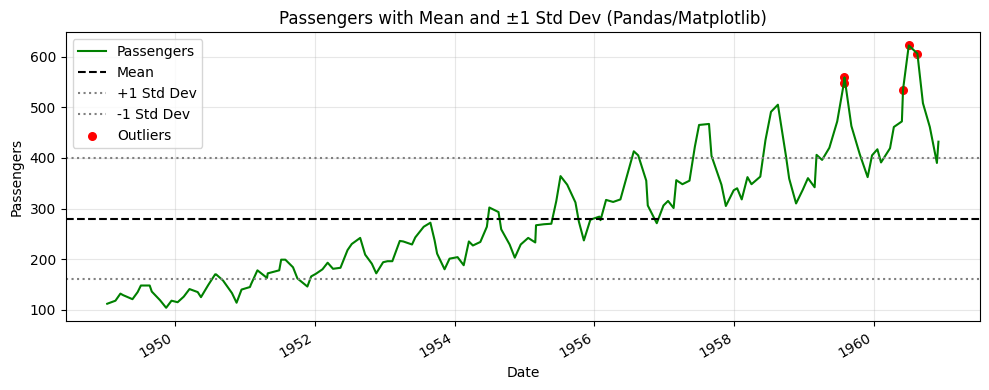

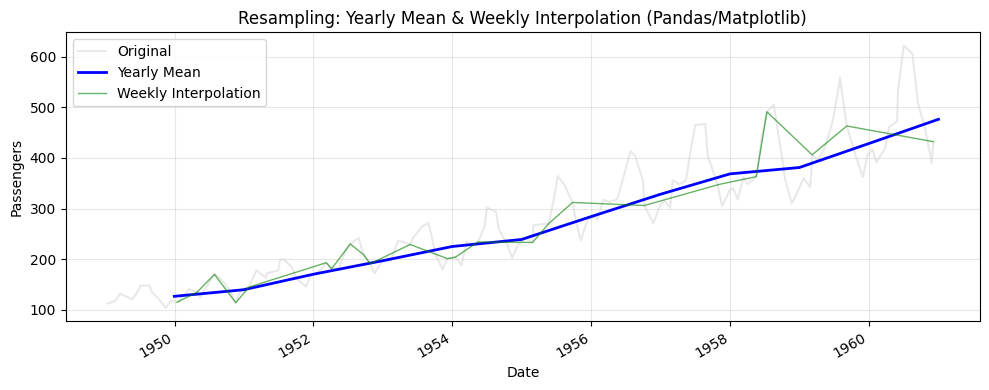

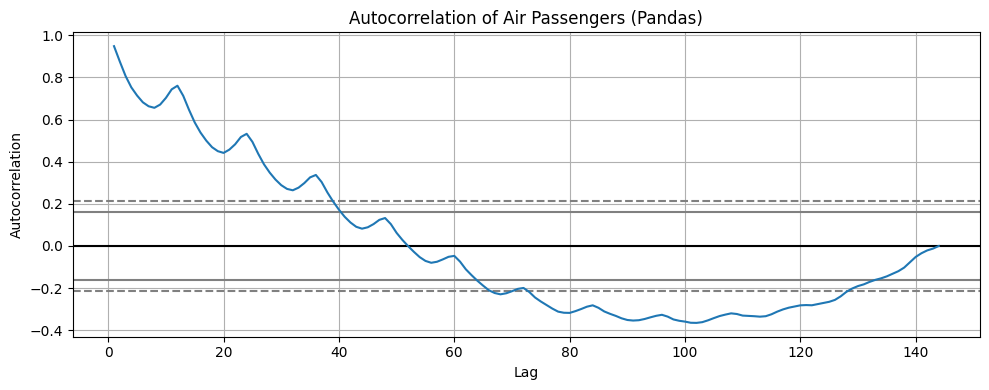

📊 All visualizations displayed in notebook (Bokeh and Pandas/Matplotlib)


In [1]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, HoverTool
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Activate notebook output
output_notebook()

# Load data
df = pd.read_csv("C:/Users/victo/Documents/GitHub/Data_Visualization_Course/Data_Visualization_Course/lab-sessions/datasets/AirPassengersDates.csv")
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df.set_index('Date', inplace=True)

#############################################
# PARTIE 1: VISUALISATIONS AVEC BOKEH
#############################################

# ----------------------
# 1. Annual bar plot - Bokeh
# ----------------------
df_yearly = df.resample('YE').sum()
df_yearly.index = df_yearly.index.year.astype(str)
yearly_source = ColumnDataSource(df_yearly.reset_index())

bar_plot = figure(x_range=yearly_source.data['Date'],
                 title="Total Passengers per Year (Bokeh)",
                 x_axis_label='Year', y_axis_label='Total Passengers',
                 height=300, width=800, tools="pan,box_zoom,reset,save")

bar_plot.vbar(x='Date', top='Passengers', width=0.8, source=yearly_source, color="orange")
bar_plot.add_tools(HoverTool(tooltips=[("Year", "@Date"), ("Passengers", "@Passengers")]))

# ----------------------
# 2. Mean + std dev + outliers - Bokeh
# ----------------------
mean = df['Passengers'].mean()
std = df['Passengers'].std()

mean_plot = figure(title="Passengers with Mean and ±1 Std Dev (Bokeh)",
                 x_axis_type='datetime', x_axis_label='Date', y_axis_label='Passengers',
                 height=300, width=800, tools="pan,box_zoom,reset,save")

mean_plot.line(df.index, df['Passengers'], line_width=2, color="green", legend_label="Passengers")
mean_plot.line(df.index, [mean]*len(df), line_dash='dashed', color='black', legend_label="Mean")
mean_plot.line(df.index, [mean + std]*len(df), line_dash='dotted', color='gray', legend_label="+1 Std Dev")
mean_plot.line(df.index, [mean - std]*len(df), line_dash='dotted', color='gray', legend_label="-1 Std Dev")

outliers = df[(df['Passengers'] > mean + 2*std) | (df['Passengers'] < mean - 2*std)]
outlier_source = ColumnDataSource(data={
    'date': outliers.index,
    'passengers': outliers['Passengers']
})
mean_plot.scatter('date', 'passengers', size=8, source=outlier_source, color='red', legend_label="Outliers")

# ----------------------
# 3. Resampling (down & up) - Bokeh
# ----------------------
df_downsampled = df.resample('YE').mean()
df_upsampled = df.resample('W').interpolate('linear')

resample_plot = figure(title="Resampling: Yearly Mean & Weekly Interpolation (Bokeh)",
                      x_axis_type='datetime', height=300, width=800)

resample_plot.line(df.index, df['Passengers'], color="lightgray", legend_label="Original")
resample_plot.line(df_downsampled.index, df_downsampled['Passengers'], color="blue", line_width=2, legend_label="Yearly Mean")
resample_plot.line(df_upsampled.index, df_upsampled['Passengers'], color="green", line_width=1, alpha=0.6, legend_label="Weekly Interpolation")

# ----------------------
# 4. Autocorrelation (matplotlib)
# ----------------------
fig_acf, ax_acf = plt.subplots(figsize=(10, 4))
plot_acf(df['Passengers'], ax=ax_acf, lags=40)
ax_acf.set_title("Autocorrelation of Air Passengers (Original)")
plt.tight_layout()

#############################################
# PARTIE 2: VISUALISATIONS AVEC PANDAS/MATPLOTLIB
#############################################

# ----------------------
# 1. Annual bar plot - Pandas/Matplotlib
# ----------------------
plt.figure(figsize=(10, 4))
df_yearly['Passengers'].plot(kind='bar', color='blue')
plt.title('Total Passengers per Year (Pandas/Matplotlib)')
plt.xlabel('Year')
plt.ylabel('Total Passengers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# ----------------------
# 2. Mean + std dev + outliers - Pandas/Matplotlib
# ----------------------
plt.figure(figsize=(10, 4))
df['Passengers'].plot(label='Passengers', color='green')
plt.axhline(mean, linestyle='--', color='black', label='Mean')
plt.axhline(mean + std, linestyle=':', color='gray', label='+1 Std Dev')
plt.axhline(mean - std, linestyle=':', color='gray', label='-1 Std Dev')
plt.scatter(outliers.index, outliers['Passengers'], color='red', s=30, label='Outliers')
plt.title('Passengers with Mean and ±1 Std Dev (Pandas/Matplotlib)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# ----------------------
# 3. Resampling (down & up) - Pandas/Matplotlib
# ----------------------
plt.figure(figsize=(10, 4))
df['Passengers'].plot(color='lightgray', alpha=0.5, label='Original')
df_downsampled['Passengers'].plot(color='blue', linewidth=2, label='Yearly Mean')
df_upsampled['Passengers'].plot(color='green', linewidth=1, alpha=0.6, label='Weekly Interpolation')
plt.title('Resampling: Yearly Mean & Weekly Interpolation (Pandas/Matplotlib)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# ----------------------
# 4. Autocorrelation (Pandas/Matplotlib)
# ----------------------
fig_acf2, ax_acf2 = plt.subplots(figsize=(10, 4))
pd.plotting.autocorrelation_plot(df['Passengers'], ax=ax_acf2)
ax_acf2.set_title("Autocorrelation of Air Passengers (Pandas)")
plt.tight_layout()

# ----------------------
# 5. Display everything
# ----------------------
# Show Bokeh plots
show(column(bar_plot, mean_plot, resample_plot))

# Show all matplotlib plots
plt.show()

print("📊 All visualizations displayed in notebook (Bokeh and Pandas/Matplotlib)")